# Analysis of head mold impact on structural MRI data

1. Assess mold impact on **head motion**
  * motion estimated using specialized MRI sequence with embedded volumetric navigators (vNAV)
2. Assess mold impact on **image quality**
  * visual inspection performed by blinded raters (gold standard)
  * data-driven quality estimates (CAT12 IQR and FS Euler number)
3. Assess mold impact on **brain volume estimates** from 3 different tools
  * FSL's SIENA
  * CAT12
  * FreeSurfer

In [2]:
import glob
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
%load_ext rpy2.ipython

# Load participant data

In [3]:
sub_coding = pd.read_csv('sub_coding.csv')
# df.replace({"col1": di})
sub_coding.replace({'ses': {1:'A',2:'B'}}, inplace = True)
sub_coding['sub'] = sub_coding['sub'].astype(str)
sub_coding['sub'] = sub_coding['sub'].apply(lambda x: x.zfill(3))
sub_coding['dx'] = sub_coding['dx'].map({'norm': 'TDC', 'adhd': 'ADHD'})
sub_coding['cond'] = sub_coding['cond'].map({'mold+': 'MOLD+', 'mold-': 'MOLD-'})
sub_coding.head()

,sub,ses,cond,dx
0,003,A,MOLD+,TDC
1,003,B,MOLD-,TDC
2,004,A,MOLD-,TDC
3,004,B,MOLD+,TDC
4,005,A,MOLD-,TDC


In [4]:
sub_demogs = pd.read_excel('Motion_Demo&Scheduler.xlsx')
sub_demogs = sub_demogs[:21]
sub_demogs.rename(columns={"MRI SCREEN ID": "sub", "Age": "age"}, inplace = True)
sub_demogs.age = sub_demogs.age.astype(int)

sub_demogs['sub'] = sub_demogs['sub'].astype(str)
sub_demogs['sub'] = sub_demogs['sub'].apply(lambda x: x.zfill(3))

sub_demogs = sub_demogs[['sub', 'SWAN/SCARED RECORD', 'age']]

sub_demogs['SWAN/SCARED RECORD'] = sub_demogs['SWAN/SCARED RECORD'].astype(str)
sub_demogs['SWAN/SCARED RECORD'] = sub_demogs['SWAN/SCARED RECORD'].apply(lambda x: x.zfill(3))


sub_demogs = sub_demogs.merge(sub_coding[sub_coding['ses'] == 'A'], on = 'sub')


sub_demogs.head()

,sub,SWAN/SCARED RECORD,age,ses,cond,dx
0,003,014,10,A,MOLD+,TDC
1,004,015,7,A,MOLD-,TDC
2,005,016,9,A,MOLD-,TDC
3,007,011,8,A,MOLD-,TDC
4,008,013,5,A,MOLD+,TDC


In [5]:
swan_scared = pd.read_csv(r'/MotionRobustBrainMRI_DATA_LABELS_2020-10-14_1357.csv', encoding = 'iso-8859_1')
swan_scared = swan_scared[['Record ID', 'Panic Disorder or Significant Somatic Symptoms score',
                           'Generalized Anxiety Disorder Score',
                           'Separation Anxiety Disorder Score',
                           'Social Anxiety Disorder Score',
                           'School Avoidance Disorder Score', 'Total', 'ADHD Inattentive score', 'ADHD Hyperactive/Impulsive Score']][:21]

swan_scared.rename(columns={"Record ID": "SWAN/SCARED RECORD", 'Panic Disorder or Significant Somatic Symptoms score': 'Panic', 
                            'Generalized Anxiety Disorder Score': 'Generalized Anxiety',
                            'Separation Anxiety Disorder Score': 'Separation Anxiety',
                            'Social Anxiety Disorder Score': 'Social Anxiety',
                            'School Avoidance Disorder Score': 'School Avoidance', 
                            "Total": "total_anxiety"}, inplace = True)
swan_scared['SWAN/SCARED RECORD'] = swan_scared['SWAN/SCARED RECORD'].astype(int).astype(str)
swan_scared['SWAN/SCARED RECORD'] = swan_scared['SWAN/SCARED RECORD'].apply(lambda x: x.zfill(3))

sub_demogs = sub_demogs.merge(swan_scared, on = 'SWAN/SCARED RECORD', how = 'outer')
sub_demogs = sub_demogs[sub_demogs['sub'].notna()]

sub_demogs.drop(['ses', 'cond', 'SWAN/SCARED RECORD'], axis=1, inplace=True)

sub_demogs.head()

,sub,age,dx,Panic,Generalized Anxiety,Separation Anxiety,Social Anxiety,School Avoidance,total_anxiety,ADHD Inattentive score,ADHD Hyperactive/Impulsive Score
0,003,10.0,TDC,3.0,3.0,6.0,0.0,0.0,12.0,2.0,4.0
1,004,7.0,TDC,2.0,6.0,5.0,9.0,0.0,22.0,1.0,0.0
2,005,9.0,TDC,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN
3,007,8.0,TDC,2.0,7.0,1.0,8.0,0.0,18.0,0.0,1.0
4,008,5.0,TDC,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0


In [6]:
sub_demogs['ADHD_Subtype'] = ''
sub_demogs.loc[(sub_demogs['ADHD Inattentive score'] <= 6) & (sub_demogs['dx'] == 'ADHD'), 'ADHD_Subtype'] = 'ADHD-NOS'
sub_demogs.loc[sub_demogs['ADHD Inattentive score'] >= 6, 'ADHD_Subtype'] = 'ADHD-I'
sub_demogs.loc[sub_demogs['ADHD Hyperactive/Impulsive Score'] >= 6, 'ADHD_Subtype'] = 'ADHD-H'
sub_demogs.loc[(sub_demogs['ADHD Inattentive score'] >= 6) & (sub_demogs['ADHD Hyperactive/Impulsive Score'] >= 6), 'ADHD_Subtype'] = 'ADHD-C'

# sub_demogs.loc[sub_demogs['ADHD_Subtype'] == '', 'ADHD_Subtype'] = 'None'  
# sub_demogs['ADHD_Subtype'] = sub_demogs['ADHD_Subtype'].fillna('s')
sub_demogs

,sub,age,dx,Panic,Generalized Anxiety,Separation Anxiety,Social Anxiety,School Avoidance,total_anxiety,ADHD Inattentive score,ADHD Hyperactive/Impulsive Score,ADHD_Subtype
0,003,10.0,TDC,3.0,3.0,6.0,0.0,0.0,12.0,2.0,4.0,
1,004,7.0,TDC,2.0,6.0,5.0,9.0,0.0,22.0,1.0,0.0,
2,005,9.0,TDC,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,
3,007,8.0,TDC,2.0,7.0,1.0,8.0,0.0,18.0,0.0,1.0,
4,008,5.0,TDC,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,
5,009,8.0,TDC,1.0,3.0,0.0,1.0,0.0,5.0,0.0,0.0,
6,010,7.0,TDC,1.0,0.0,0.0,3.0,0.0,4.0,0.0,0.0,
7,011,6.0,TDC,2.0,2.0,3.0,4.0,0.0,11.0,3.0,2.0,
8,012,8.0,TDC,1.0,1.0,1.0,0.0,0.0,3.0,4.0,2.0,
9,013,6.0,TDC,1.0,0.0,1.0,4.0,0.0,6.0,0.0,0.0,


# Head motion estimates (vNAV)

In [7]:
# read in vnav data
mean_rms = pd.read_csv('../../child_motion_rms_tr2.5s.csv', sep = '\t')
mean_rms['scan number'] = mean_rms['scan number'].str[:-1].apply(lambda x: x.zfill(3))

# select struct only
mean_rms = pd.melt(mean_rms[['scan number', '(s) mean-rms A (+) mm/min', '(s) mean-rms B (-) mm/min']], id_vars = 'scan number')

mean_rms = mean_rms.replace({"variable": {'(s) mean-rms A (+) mm/min': "mold+", '(s) mean-rms B (-) mm/min': "mold-"}})
mean_rms = mean_rms.rename({'scan number': 'sub', 'variable': 'cond', 'value':'mean_rms'}, axis=1) 
mean_rms['cond'] = mean_rms['cond'].map({'mold+': 'MOLD+', 'mold-': 'MOLD-'})
mean_rms = pd.merge(mean_rms, sub_coding.loc[sub_coding['ses'] == 'A'][['sub', 'dx']], on = 'sub')

mean_rms.head()



,sub,cond,mean_rms,dx
0,003,MOLD+,3.130087,TDC
1,003,MOLD-,3.493332,TDC
2,004,MOLD+,3.191968,TDC
3,004,MOLD-,4.466768,TDC
4,005,MOLD+,6.545898,TDC


In [139]:
mean_rms_wide = mean_rms.pivot_table(index = ['sub','dx'], columns = 'cond', values = 'mean_rms').reset_index()


In [17]:
mean_rms_wide['diff'] = mean_rms_wide['mold-'] - mean_rms_wide['mold+']

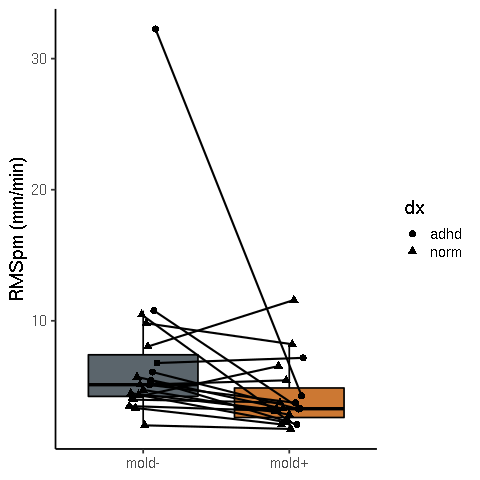

In [95]:
%%R -i mean_rms
library(likert) 
library(dplyr)
library(ggplot2)

mean_rms %>%
    ggplot(aes(x=cond, y=value)) + 
    geom_boxplot(aes(fill = cond), alpha = 0.8, size = .8, col = "black", outlier.shape = NA) +
    scale_fill_manual(values=c( '#333f48', '#BF5700')) +
    geom_line(aes(group = sub), size = 1, position = position_dodge(0.2)) + 
    geom_point(aes(fill=cond,group=sub, shape = dx), size = 3, position = position_dodge(0.2)) +
    ylab("RMSpm (mm/min)") + theme(axis.title.x = element_blank()) + theme_classic(base_size=18) + guides(fill = FALSE) + theme(axis.title.x = element_blank())
    
# ggsave('figs/rmspm.png', dpi = 300)

<Figure size 640x480 with 0 Axes>

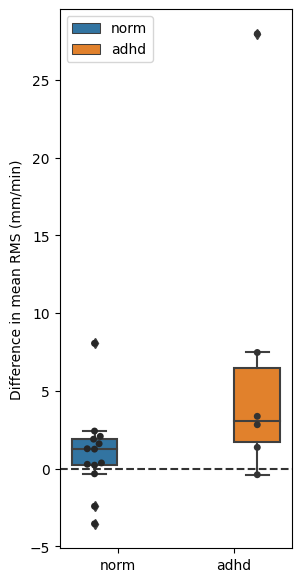

In [169]:
plt.rcdefaults()
plt.clf()

plt.figure(figsize=(3,7))  
ax = sns.boxplot(y="diff", x="dx", data=mean_rms_wide, orient = 'v', hue = 'dx' )
ax = sns.swarmplot(y="diff", x="dx", data=mean_rms_wide, hue = 'dx', orient = 'v', color = '.2', dodge = True)

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[:2], labels[:2])

ax.set(xlabel='', ylabel='Difference in mean RMS (mm/min)')
ax.axhline(0, ls='--', color = '.2')
plt.savefig('figs/mean-rms_diff_box.png', dpi=300)
plt.show()

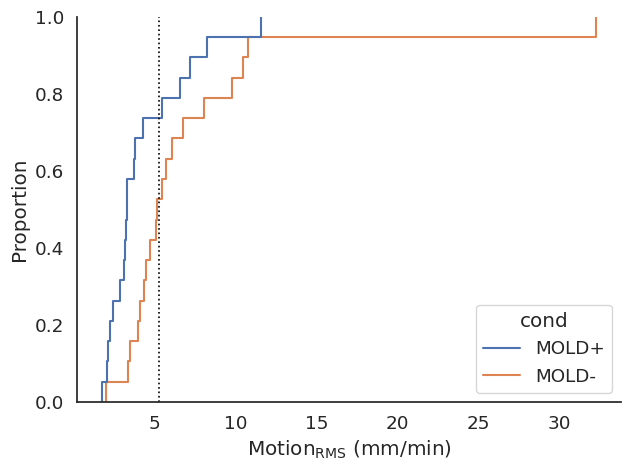

In [68]:
plt.rcdefaults()
plt.clf()
params = {'mathtext.default': 'regular' }          
plt.rcParams.update(params)
sns.set(style="white", font_scale=1.2)
sns.despine()

sns.ecdfplot(data=mean_rms, x="mean_rms", hue="cond")

plt.xlabel('$Motion_{RMS}$ (mm/min)')
sns.despine()
sns.set_context("paper")
plt.axvline(x=5.29, c = 'black', linestyle = ':')
plt.tight_layout()

plt.savefig('figs/struct_rms_cdf.png',dpi = 300)
plt.show()


In [199]:
mean_rms.head()

,sub,cond,mean_rms,dx,age,total_anxiety
0,003,MOLD+,3.130087,TDC,10.0,12.0
1,003,MOLD-,3.493332,TDC,10.0,12.0
2,004,MOLD+,3.191968,TDC,7.0,22.0
3,004,MOLD-,4.466768,TDC,7.0,22.0
4,005,MOLD+,6.545898,TDC,9.0,0.0


In [201]:
%%R

m1 <- lme(mean_rms ~ cond, random = ~1|sub, data=mean_rms)
anova(m1)

            numDF denDF  F-value p-value
(Intercept)     1    18 45.62223  <.0001
cond            1    18  3.67673  0.0712


In [165]:
mean_rms.head()

,sub,cond,mean_rms,dx
0,003,MOLD+,3.130087,TDC
1,003,MOLD-,3.493332,TDC
2,004,MOLD+,3.191968,TDC
3,004,MOLD-,4.466768,TDC
4,005,MOLD+,6.545898,TDC


In [167]:
from scipy.stats import levene, ttest_ind
print(levene(mean_rms[(mean_rms['cond'] == 'MOLD+') & (mean_rms['dx'] == 'TDC')]['mean_rms'], mean_rms[(mean_rms['cond'] == 'MOLD+') & (mean_rms['dx'] == 'ADHD')]['mean_rms'] ))

print(ttest_ind(mean_rms[(mean_rms['cond'] == 'MOLD+') & (mean_rms['dx'] == 'TDC')]['mean_rms'], mean_rms[(mean_rms['cond'] == 'MOLD+') & (mean_rms['dx'] == 'ADHD')]['mean_rms'] ))

LeveneResult(statistic=0.533998790986657, pvalue=0.47488231654197177)
Ttest_indResult(statistic=0.28873104095842006, pvalue=0.7762783167932837)


In [168]:
from scipy.stats import levene, ttest_ind
print(levene(mean_rms[(mean_rms['cond'] == 'MOLD-') & (mean_rms['dx'] == 'TDC')]['mean_rms'], mean_rms[(mean_rms['cond'] == 'MOLD-') & (mean_rms['dx'] == 'ADHD')]['mean_rms'] ))

print(ttest_ind(mean_rms[(mean_rms['cond'] == 'MOLD-') & (mean_rms['dx'] == 'TDC')]['mean_rms'], mean_rms[(mean_rms['cond'] == 'MOLD-') & (mean_rms['dx'] == 'ADHD')]['mean_rms'] ))

LeveneResult(statistic=1.8112529795985153, pvalue=0.19603324465904692)
Ttest_indResult(statistic=-1.893548287202409, pvalue=0.0754329826276304)


In [188]:
# join head motion df with sub_demogs

mean_rms = mean_rms.merge(sub_demogs[['sub', 'age', 'total_anxiety']], on = 'sub')


In [198]:
mean_rms

,sub,cond,mean_rms,dx,age,total_anxiety
0,003,MOLD+,3.130087,TDC,10.0,12.0
1,003,MOLD-,3.493332,TDC,10.0,12.0
2,004,MOLD+,3.191968,TDC,7.0,22.0
3,004,MOLD-,4.466768,TDC,7.0,22.0
4,005,MOLD+,6.545898,TDC,9.0,0.0
5,005,MOLD-,4.120252,TDC,9.0,0.0
6,007,MOLD+,3.764022,TDC,8.0,18.0
7,007,MOLD-,3.984451,TDC,8.0,18.0
8,008,MOLD+,2.094816,TDC,5.0,1.0
9,008,MOLD-,3.345986,TDC,5.0,1.0


In [191]:
# correlate head motion with anxiety and adhd

from scipy.stats.stats import pearsonr

print('total_anxiety')
print('MOLD- : ', pearsonr(mean_rms[mean_rms['cond'] == 'MOLD-']['total_anxiety'], mean_rms[mean_rms['cond'] == 'MOLD-']['mean_rms']))
print('MOLD+ : ', pearsonr(mean_rms[mean_rms['cond'] == 'MOLD+']['total_anxiety'], mean_rms[mean_rms['cond'] == 'MOLD+']['mean_rms']))
print('\nage')
print('MOLD- : ', pearsonr(mean_rms[mean_rms['cond'] == 'MOLD-']['age'], mean_rms[mean_rms['cond'] == 'MOLD-']['mean_rms']))
print('MOLD+ : ', pearsonr(mean_rms[mean_rms['cond'] == 'MOLD+']['age'], mean_rms[mean_rms['cond'] == 'MOLD+']['mean_rms']))

total_anxiety
MOLD- :  (-0.14064884587268156, 0.5657509725939933)
MOLD+ :  (0.11784776516961362, 0.630876829239067)

age
MOLD- :  (-0.14337294531728745, 0.5581714280406959)
MOLD+ :  (0.11693753587399458, 0.6335359144487319)


# Image Quality | Visual inspection and manual ratings

In [8]:
mean_rms.head()

,sub,cond,mean_rms,dx
0,003,MOLD+,3.130087,TDC
1,003,MOLD-,3.493332,TDC
2,004,MOLD+,3.191968,TDC
3,004,MOLD-,4.466768,TDC
4,005,MOLD+,6.545898,TDC


In [9]:
# results from blind ratings
struct_qa = pd.read_csv('/scratch/06028/tbweng/child-motion/scores.csv')

# contains key for anonymized id
anon_key = pd.read_csv('/scratch/06028/tbweng/child-motion/defaced/anonymized.csv')


struct_qa = struct_qa[['default','rater1','rater2','rater3','rater4','rater5']]
struct_qa.rename(columns={'default': 'anon_id'}, inplace=True)

struct_qa = struct_qa.merge(anon_key[['anon_id', 'orig_id']], on = 'anon_id')
struct_qa[['sub','ses']] = struct_qa.orig_id.str.split("_",expand=True) 

struct_qa['sub'] = struct_qa['sub'].str.strip('sub-mot')
struct_qa.ses = struct_qa.ses.str.strip('run-')
struct_qa = struct_qa.astype({'ses': 'int64'})
struct_qa.replace({'ses': {1:'A',2:'B'}}, inplace = True)

# join with sub coding table
struct_qa = struct_qa.merge(sub_coding, on = ['sub', 'ses'])
struct_qa = struct_qa.merge(mean_rms[['sub', 'cond', 'mean_rms']], on = ['sub', 'cond'])

# use mode of 5 raters
struct_qa['mode'] = struct_qa.filter(like='rater').mode(axis=1).iloc[:, 0]

struct_qa.head()
struct_qa.to_csv('/home1/06028/tbweng/struct_qc_ratings.csv')

In [10]:
struct_qa

,anon_id,rater1,rater2,rater3,rater4,rater5,orig_id,sub,ses,cond,dx,mean_rms,mode
0,0,4,4,4,4,4,sub-mot003_run-01,003,A,MOLD+,TDC,3.130087,4.0
1,1,3,4,4,4,4,sub-mot021_run-01,021,A,MOLD+,ADHD,3.305602,4.0
2,2,3,3,4,4,4,sub-mot011_run-01,011,A,MOLD-,TDC,5.123333,4.0
3,3,4,3,4,4,4,sub-mot018_run-01,018,A,MOLD+,ADHD,2.096649,4.0
4,4,2,3,2,2,3,sub-mot011_run-02,011,B,MOLD+,TDC,5.460302,2.0
5,5,4,4,4,3,3,sub-mot013_run-01,013,A,MOLD-,TDC,4.731986,4.0
6,6,4,4,4,4,3,sub-mot014_run-01,014,A,MOLD+,TDC,1.748213,4.0
7,7,4,5,4,3,4,sub-mot004_run-02,004,B,MOLD+,TDC,3.191968,4.0
8,8,2,3,3,2,3,sub-mot015_run-02,015,B,MOLD+,TDC,8.207279,3.0
9,9,2,2,3,3,4,sub-mot022_run-02,022,B,MOLD+,ADHD,4.290978,2.0


In [11]:
struct_qa[['mode1','mode2']] = struct_qa.filter(like='rater').mode(axis=1)
struct_qa['median'] = struct_qa.filter(like='rater').median(axis=1)

In [12]:
# if 2 modes, take median
struct_qa['mode'] = np.where(struct_qa['mode2'].isnull(), struct_qa['mode1'], struct_qa['median'])

# subset df
struct_qa = struct_qa[['sub', 'ses', 'cond', 'dx', 'mean_rms', 'mode']]
struct_qa

,sub,ses,cond,dx,mean_rms,mode
0,003,A,MOLD+,TDC,3.130087,4.0
1,021,A,MOLD+,ADHD,3.305602,4.0
2,011,A,MOLD-,TDC,5.123333,4.0
3,018,A,MOLD+,ADHD,2.096649,4.0
4,011,B,MOLD+,TDC,5.460302,2.0
5,013,A,MOLD-,TDC,4.731986,4.0
6,014,A,MOLD+,TDC,1.748213,4.0
7,004,B,MOLD+,TDC,3.191968,4.0
8,015,B,MOLD+,TDC,8.207279,3.0
9,022,B,MOLD+,ADHD,4.290978,3.0


In [13]:
# use 3 as threshold for pass/fail
struct_qa.loc[struct_qa['mode'] > 3, 'qc'] = 'pass'
struct_qa.loc[struct_qa['mode'] == 3, 'qc'] = 'warn'
struct_qa.loc[struct_qa['mode'] < 3, 'qc'] = 'fail'

struct_qa

/home1/06028/tbweng/miniconda3/lib/python3.7/site-packages/pandas/core/indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/home1/06028/tbweng/miniconda3/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


,sub,ses,cond,dx,mean_rms,mode,qc
0,003,A,MOLD+,TDC,3.130087,4.0,pass
1,021,A,MOLD+,ADHD,3.305602,4.0,pass
2,011,A,MOLD-,TDC,5.123333,4.0,pass
3,018,A,MOLD+,ADHD,2.096649,4.0,pass
4,011,B,MOLD+,TDC,5.460302,2.0,fail
5,013,A,MOLD-,TDC,4.731986,4.0,pass
6,014,A,MOLD+,TDC,1.748213,4.0,pass
7,004,B,MOLD+,TDC,3.191968,4.0,pass
8,015,B,MOLD+,TDC,8.207279,3.0,warn
9,022,B,MOLD+,ADHD,4.290978,3.0,warn


In [14]:
# max rms for pass 
struct_qa[struct_qa['qc'] == 'pass']['mean_rms'].max()

5.12333328

In [15]:
# min rms for fail 
struct_qa[struct_qa['qc'] == 'fail']['mean_rms'].min()

5.457819241

In [222]:
# midpoint between upper pass and lower fail
(struct_qa[struct_qa['qc'] == 'pass']['mean_rms'].max() + struct_qa[struct_qa['qc'] == 'fail']['mean_rms'].min())/2

5.2905762605

In [16]:
# label pass/fail based on mean_rms boundary 5.29
struct_qa.loc[struct_qa['mean_rms'] > 5.29, 'qc_rms'] = 0
struct_qa.loc[struct_qa['mean_rms'] < 5.29, 'qc_rms'] = 1
# struct_qa['qc_rms'] = struct_qa['qc_rms'].astype(int)
struct_qa.head()

/home1/06028/tbweng/miniconda3/lib/python3.7/site-packages/pandas/core/indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/home1/06028/tbweng/miniconda3/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


,sub,ses,cond,dx,mean_rms,mode,qc,qc_rms
0,003,A,MOLD+,TDC,3.130087,4.0,pass,1.0
1,021,A,MOLD+,ADHD,3.305602,4.0,pass,1.0
2,011,A,MOLD-,TDC,5.123333,4.0,pass,1.0
3,018,A,MOLD+,ADHD,2.096649,4.0,pass,1.0
4,011,B,MOLD+,TDC,5.460302,2.0,fail,0.0


In [58]:

struct_qa_wide = pd.pivot_table(struct_qa, values = 'qc_rms', index=['sub', 'dx'], columns = 'cond').reset_index()
struct_qa_wide.head()

cond,sub,dx,MOLD+,MOLD-
0,003,TDC,1.0,1.0
1,004,TDC,1.0,1.0
2,005,TDC,0.0,1.0
3,007,TDC,1.0,1.0
4,008,TDC,1.0,1.0


In [60]:

struct_qa_wide_ses = pd.pivot_table(struct_qa, values = 'qc_rms', index=['sub', 'dx'], columns = 'ses').reset_index()
struct_qa_wide_ses

ses,sub,dx,A,B
0,003,TDC,1.0,1.0
1,004,TDC,1.0,1.0
2,005,TDC,1.0,0.0
3,007,TDC,1.0,1.0
4,008,TDC,1.0,1.0
5,009,TDC,1.0,0.0
6,010,TDC,1.0,1.0
7,011,TDC,1.0,0.0
8,012,TDC,0.0,1.0
9,013,TDC,1.0,1.0


In [22]:
# determine QC rating changes as a result of head mold

struct_qa_wide['rating_diff'] = struct_qa_wide['MOLD+'] - struct_qa_wide['MOLD-']

struct_qa_wide.loc[(struct_qa_wide['rating_diff'] == 0) & (struct_qa_wide['MOLD+'] == 0), 'rating'] = 'fail-fail'
struct_qa_wide.loc[(struct_qa_wide['rating_diff'] == 0) & (struct_qa_wide['MOLD+'] == 1), 'rating'] = 'pass-pass'
struct_qa_wide.loc[struct_qa_wide['rating_diff'] == 1, 'rating'] = 'fail-pass'
struct_qa_wide.loc[struct_qa_wide['rating_diff'] == -1, 'rating'] = 'pass-fail'

struct_qa_wide.head()

cond,sub,dx,MOLD+,MOLD-,rating_diff,rating
0,003,TDC,1.0,1.0,0.0,pass-pass
1,004,TDC,1.0,1.0,0.0,pass-pass
2,005,TDC,0.0,1.0,-1.0,pass-fail
3,007,TDC,1.0,1.0,0.0,pass-pass
4,008,TDC,1.0,1.0,0.0,pass-pass


In [61]:
struct_qa_wide_ses['rating_diff'] = struct_qa_wide_ses['B'] - struct_qa_wide_ses['A']

struct_qa_wide_ses.loc[(struct_qa_wide_ses['rating_diff'] == 0) & (struct_qa_wide_ses['B'] == 0), 'rating'] = 'fail-fail'
struct_qa_wide_ses.loc[(struct_qa_wide_ses['rating_diff'] == 0) & (struct_qa_wide_ses['B'] == 1), 'rating'] = 'pass-pass'
struct_qa_wide_ses.loc[struct_qa_wide_ses['rating_diff'] == 1, 'rating'] = 'fail-pass'
struct_qa_wide_ses.loc[struct_qa_wide_ses['rating_diff'] == -1, 'rating'] = 'pass-fail'

struct_qa_wide_ses.head()

ses,sub,dx,A,B,rating_diff,rating
0,003,TDC,1.0,1.0,0.0,pass-pass
1,004,TDC,1.0,1.0,0.0,pass-pass
2,005,TDC,1.0,0.0,-1.0,pass-fail
3,007,TDC,1.0,1.0,0.0,pass-pass
4,008,TDC,1.0,1.0,0.0,pass-pass


In [23]:
sub_demogs.head()

,sub,age,dx,Panic,Generalized Anxiety,Separation Anxiety,Social Anxiety,School Avoidance,total_anxiety,ADHD Inattentive score,ADHD Hyperactive/Impulsive Score,ADHD_Subtype
0,003,10.0,TDC,3.0,3.0,6.0,0.0,0.0,12.0,2.0,4.0,
1,004,7.0,TDC,2.0,6.0,5.0,9.0,0.0,22.0,1.0,0.0,
2,005,9.0,TDC,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,
3,007,8.0,TDC,2.0,7.0,1.0,8.0,0.0,18.0,0.0,1.0,
4,008,5.0,TDC,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,


In [24]:
struct_qa_wide = struct_qa_wide.merge(sub_demogs[['sub','age','total_anxiety', 'ADHD_Subtype']], on = 'sub')

In [62]:
struct_qa_wide_ses = struct_qa_wide_ses.merge(sub_demogs[['sub','age','total_anxiety', 'ADHD_Subtype']], on = 'sub')

In [25]:

struct_qa_wide.age = struct_qa_wide.age.astype(int)

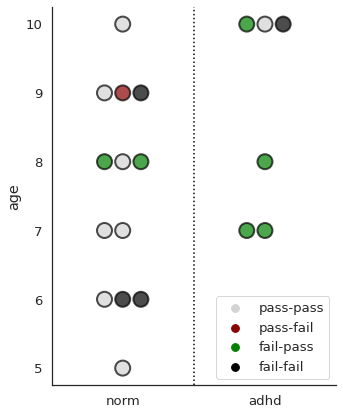

In [53]:
# plot impact of head mold on scan quality (shape color) as a function of age (y axis) and ADHD diagnosis (x axis)

sns.set(style="white", font_scale=1.2)
fig, ax = plt.subplots(figsize=(5, 6))
sns.swarmplot(x = 'dx', y = 'age', hue = 'rating', size = 15, data = struct_qa_wide, palette = ['lightgray', 'darkred', 'green', 'black'], linewidth = 2, edgecolor = 'black', alpha = .7)
ax.set_xlabel('') 
ax.axvline(.5, ls=':', color = 'black')

plt.legend(loc='lower right',numpoints=1)
sns.despine()
plt.tight_layout()
plt.savefig('figs/sMRI_swarmplot_dx_age.png', dpi = 300)
plt.show()


In [90]:
# join in adhd and anxiety values

struct_qa_wide = struct_qa_wide.merge(sub_demogs[['sub', 'ADHD_Subtype', 'total_anxiety']], on='sub')

struct_qa_wide.head()

,sub,dx,MOLD+,MOLD-,ADHD_Subtype,total_anxiety
0,003,TDC,1.0,1.0,,12.0
1,004,TDC,1.0,1.0,,22.0
2,005,TDC,0.0,1.0,,0.0
3,007,TDC,1.0,1.0,,18.0
4,008,TDC,1.0,1.0,,1.0


'data.frame':	19 obs. of  9 variables:
 $ sub          : chr  "003" "004" "005" "007" ...
 $ dx           : chr  "TDC" "TDC" "TDC" "TDC" ...
 $ MOLD+        : num  1 1 0 1 1 1 1 0 1 1 ...
 $ MOLD-        : num  1 1 1 1 1 0 1 1 0 1 ...
 $ rating_diff  : num  0 0 -1 0 0 1 0 -1 1 0 ...
 $ rating       : chr  "pass-pass" "pass-pass" "pass-fail" "pass-pass" ...
 $ age          : int  10 7 9 8 5 8 7 6 8 6 ...
 $ ADHD_Subtype : Factor w/ 4 levels "Sub-threshold",..: 1 1 1 1 1 1 1 1 1 1 ...
 $ total_anxiety: num  12 22 0 18 1 5 4 11 3 6 ...


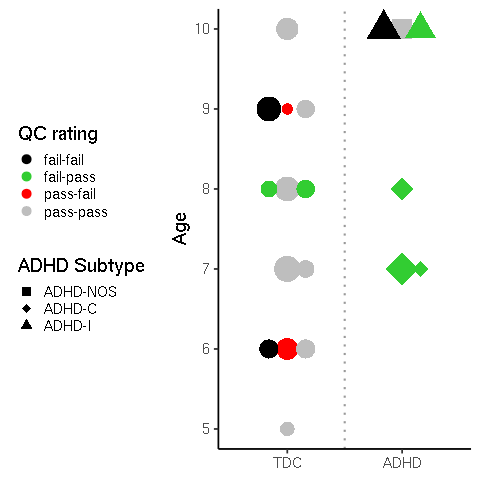

In [55]:
# plot impact of head mold on scan quality (shape color) as a function of age (y axis), ADHD diagnosis (x axis) and anxiety (shape size)

%%R -i struct_qa_wide

library(ggbeeswarm)
struct_qa_wide$ADHD_Subtype[struct_qa_wide$ADHD_Subtype=='']='Sub-threshold'

struct_qa_wide$ADHD_Subtype <- factor(struct_qa_wide$ADHD_Subtype, levels = c("Sub-threshold", "ADHD-NOS", "ADHD-C", "ADHD-I"))
str(struct_qa_wide)

beeswarm <- ggplot(struct_qa_wide, aes(dx, age, group = rating, fill=rating, color = rating, shape = ADHD_Subtype, size = total_anxiety)) +
    geom_beeswarm(aes(shape=ADHD_Subtype,color=rating, fill=rating),cex = 8) +  
    scale_shape_manual(breaks = c("ADHD-NOS", "ADHD-C", "ADHD-I"), values = c(16,15,18,17), "ADHD Subtype") +
    scale_color_manual(values = c('black', 'limegreen', 'red', 'grey'), "QC rating") +
    scale_fill_manual(values = c('black', 'limegreen', 'red', 'grey'), "QC rating") + 
    scale_size(range = c(5, 15), guide = 'none') +
    scale_x_discrete(limits=c("TDC", "ADHD")) +
    geom_vline(xintercept=1.5, linetype="dotted", color = "black", size = 1, alpha = .4) +
    guides(shape = guide_legend(override.aes = list(size=4))) + 
    guides(color = guide_legend(override.aes = list(size=4))) +
    labs(y = "Age") + theme_classic(base_size=18) + theme(axis.title.x = element_blank()) +
    theme(legend.position="left")


plot(beeswarm) 

In [27]:
%%R -i struct_qa_wide -i struct_qa
library(dplyr)
library(ggplot2)

struct_qa$qc <- as.character(struct_qa$qc)
str(struct_qa)

# struct_qa$QA <- factor(struct_qa$QA, levels=c("0","1"), labels=c("Fail", "Pass"))
str(struct_qa_wide)

merge(struct_qa, struct_qa_wide %>% select(sub, rating), by = 'sub')

'data.frame':	38 obs. of  8 variables:
 $ sub     : chr  "003" "021" "011" "018" ...
 $ ses     : chr  "A" "A" "A" "A" ...
 $ cond    : chr  "MOLD+" "MOLD+" "MOLD-" "MOLD+" ...
 $ dx      : chr  "TDC" "ADHD" "TDC" "ADHD" ...
 $ mean_rms: num  3.13 3.31 5.12 2.1 5.46 ...
 $ mode    : num  4 4 4 4 2 4 4 4 3 3 ...
 $ qc      : chr  "pass" "pass" "pass" "pass" ...
 $ qc_rms  : num  1 1 1 1 0 1 1 1 0 1 ...
'data.frame':	19 obs. of  7 variables:
 $ sub        : chr  "003" "004" "005" "007" ...
 $ dx         : chr  "TDC" "TDC" "TDC" "TDC" ...
 $ MOLD+      : num  1 1 0 1 1 1 1 0 1 1 ...
 $ MOLD-      : num  1 1 1 1 1 0 1 1 0 1 ...
 $ rating_diff: num  0 0 -1 0 0 1 0 -1 1 0 ...
 $ rating     : chr  "pass-pass" "pass-pass" "pass-fail" "pass-pass" ...
 $ age        : int  10 7 9 8 5 8 7 6 8 6 ...
   sub ses  cond   dx  mean_rms mode   qc qc_rms    rating
1  003   A MOLD+  TDC  3.130087    4 pass      1 pass-pass
2  003   B MOLD-  TDC  3.493332    4 pass      1 pass-pass
3  004   A MOLD-  TDC  4.

In [31]:
struct_qa.head()

,sub,ses,cond,dx,mean_rms,mode,qc,qc_rms
0,003,A,MOLD+,TDC,3.130087,4.0,pass,1.0
1,021,A,MOLD+,ADHD,3.305602,4.0,pass,1.0
2,011,A,MOLD-,TDC,5.123333,4.0,pass,1.0
3,018,A,MOLD+,ADHD,2.096649,4.0,pass,1.0
4,011,B,MOLD+,TDC,5.460302,2.0,fail,0.0


In [30]:
struct_qa_wide.head()

,sub,dx,MOLD+,MOLD-,rating_diff,rating,age
0,003,TDC,1.0,1.0,0.0,pass-pass,10
1,004,TDC,1.0,1.0,0.0,pass-pass,7
2,005,TDC,0.0,1.0,-1.0,pass-fail,9
3,007,TDC,1.0,1.0,0.0,pass-pass,8
4,008,TDC,1.0,1.0,0.0,pass-pass,5


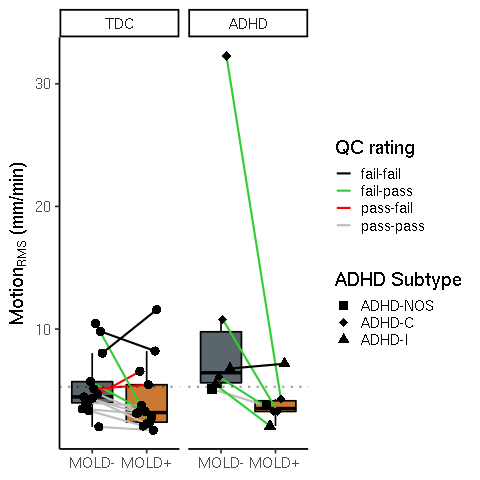

In [54]:
%%R -i struct_qa -i struct_qa_wide

library(dplyr)
library(ggplot2)

library(ggbeeswarm)

struct_qa_wide$ADHD_Subtype[struct_qa_wide$ADHD_Subtype=='']='Sub-threshold'

struct_qa_wide$ADHD_Subtype <- factor(struct_qa_wide$ADHD_Subtype, levels = c("Sub-threshold", "ADHD-NOS", "ADHD-C", "ADHD-I"))
struct_qa$dx <- factor(struct_qa$dx, levels = c("TDC", "ADHD"))
    
struct_qa$qc <- factor(struct_qa$qc, levels=c("0","1"), labels=c("Fail", "Pass"))
# str(struct_qa)

bp <- merge(struct_qa, struct_qa_wide %>% select(sub, rating, ADHD_Subtype, total_anxiety), by = 'sub') %>%
    ggplot(aes(x=cond, y=mean_rms)) + 
    geom_boxplot(aes(fill = cond), alpha = 0.8, size = .8, col = "black", outlier.shape = NA) +
    scale_fill_manual(values=c( '#333f48', '#BF5700')) +
    geom_line(aes(group = sub, col = rating), size = 1, position = position_dodge(0.4)) + 
    scale_colour_manual(values = c('black', 'limegreen', 'red', 'grey'), "QC rating") +
    scale_shape_manual(breaks = c("ADHD-NOS", "ADHD-C", "ADHD-I"), values = c(16,15,18,17), "ADHD Subtype") +
    geom_point(aes(fill=cond,group=sub, shape = ADHD_Subtype), size = 4, position = position_dodge(0.4)) +
    geom_hline(yintercept=5.29, linetype="dotted", color = "black", size = 1, alpha = .4) +
    scale_x_discrete(labels= c("MOLD-", "MOLD+")) +
    labs(y = expression(paste(Motion[RMS]," (mm/min)"))) + 
    theme(axis.title.x = element_blank()) + theme_classic(base_size=18) + guides(fill = FALSE) + theme(axis.title.x = element_blank()) +
    facet_wrap(~ dx)

plot(bp)
# ggsave('figs/rmspm.png', dpi = 300)

In [56]:
%%R
library(ggpubr)
ggarrange(bp, beeswarm, common.legend=TRUE, legend = 'bottom',
         labels=c("A","B"), font.label = list(size = 20, color = "black", face = "bold"))
ggsave('figs/Fig8.png', dpi = 300, width=14, height=10)

R[write to console]: Loading required package: magrittr



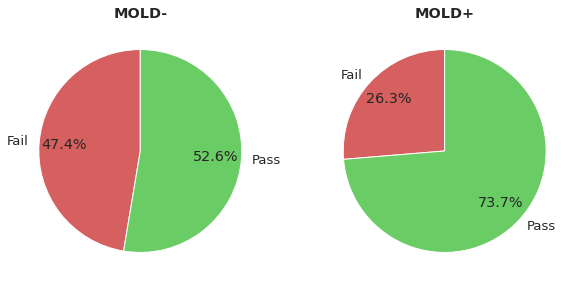

In [67]:
# plot distributions of pass/fail for MOLD- vs MOLD+

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 10))
cmap = sns.color_palette('muted')
sns.set(style="white", font_scale=1.2)
sns.despine()

labels = [ 'Fail', 'Pass' ]
sizes =  struct_qa.loc[struct_qa['cond'] == 'MOLD-'].groupby('qc_rms').count()['sub'].to_list()

ax1.pie(sizes, labels=labels, colors = [ cmap[3], cmap[2] ], autopct='%1.1f%%', startangle=90, pctdistance=0.75,
       )
ax1.set_title('MOLD-', fontweight='bold')

labels = [ 'Fail', 'Pass' ] 
sizes =  struct_qa.loc[struct_qa['cond'] == 'MOLD+'].groupby('qc_rms').count()['sub'].to_list()

ax2.pie(sizes, labels=labels, colors = [ cmap[3], cmap[2]], autopct='%1.1f%%', startangle=90, pctdistance=0.75,
       )
ax2.set_title('MOLD+', fontweight='bold')

fig.set_facecolor('white')

plt.savefig('figs/struct_qa_piechart.png', dpi = 300)
plt.show()

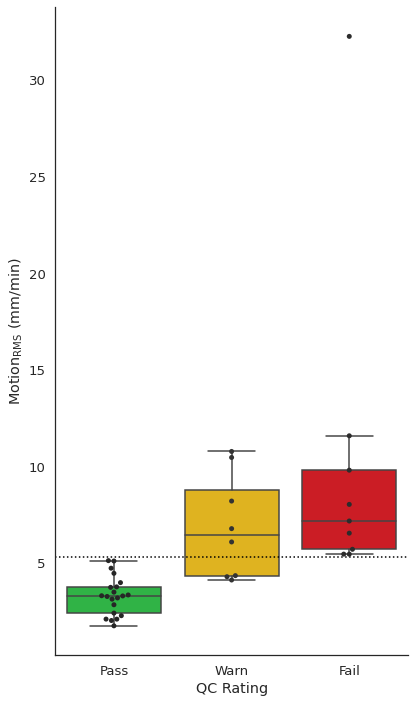

In [224]:
sns.set(style="white", font_scale=1.2)
plt.figure(figsize=(6,10))  
params = {'mathtext.default': 'regular' }  
plt.rcParams.update(params)
cmap = sns.color_palette('bright')
ax = sns.boxplot(x = 'qc', y = 'mean_rms', palette = [ cmap[2], cmap[8], cmap[3] ], orient = 'v', data = struct_qa, order = ['pass', 'warn', 'fail'], showfliers=False)
ax = sns.swarmplot(x = 'qc', y="mean_rms", data=struct_qa, hue = 'qc', orient = 'v', color = '.2', order = ['pass', 'warn', 'fail'])


ax.get_legend().remove()
plt.axhline(y=5.29, color='black', linestyle=':')
ax.set(xlabel='QC Rating', ylabel='$Motion_{RMS}\ (mm/min)$')
ax.set_xticklabels(['Pass', 'Warn', 'Fail'])
sns.despine()
plt.tight_layout()
plt.savefig('figs/manual_ratings_rms.png', dpi = 300)

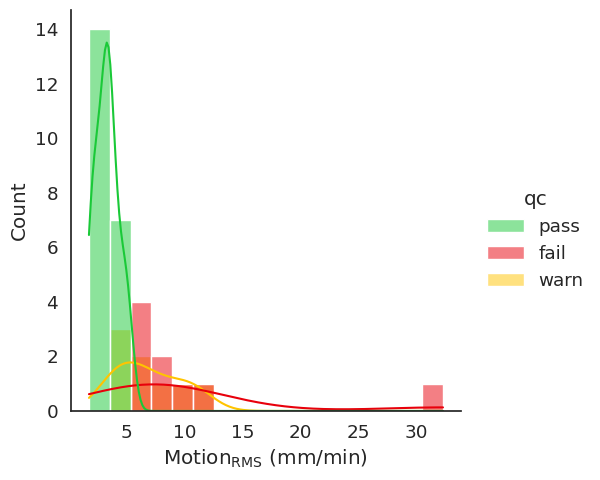

In [436]:
sns.set(style="white", font_scale=1.2)
ax = sns.displot(data=struct_qa, palette = [ cmap[2], cmap[3], cmap[8] ], fill = True, x="mean_rms", hue="qc", kde = True)

ax.set(xlabel='$Motion_{RMS}\ (mm/min)$')

## Try data-driven approach to determine boundary between pass/fail (Linear Discriminant Analysis)

In [141]:
X = struct_qa[struct_qa['value'] < 20 ].value.to_numpy().reshape(-1, 1)
y = struct_qa[struct_qa['value'] < 20 ].QA.to_numpy()

print(X)
print(y)

[[ 3.13008746]
 [ 3.49333244]
 [ 4.46676761]
 [ 3.19196756]
 [ 4.12025219]
 [ 6.54589821]
 [ 3.9844506 ]
 [ 3.76402182]
 [ 2.0948164 ]
 [ 3.34598646]
 [ 3.29590902]
 [ 5.71004246]
 [ 2.27323001]
 [ 4.34638351]
 [ 5.12333328]
 [ 5.46030195]
 [10.4636586 ]
 [ 2.40694322]
 [ 4.73198582]
 [ 2.83930514]
 [ 1.74821258]
 [ 2.02360942]
 [ 9.80663135]
 [ 8.20727883]
 [11.58604057]
 [ 8.03475654]
 [ 5.10449334]
 [ 3.74021116]
 [ 2.09664893]
 [ 5.45781924]
 [ 3.26815381]
 [ 6.0900803 ]
 [ 3.30560176]
 [10.77549909]
 [ 4.29097842]
 [ 6.77993556]
 [ 7.17498369]]
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 1 1 1 0 1 1 1 1 0 1 1]


In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

X = struct_qa.mean_rms.to_numpy().reshape(-1, 1)
y = struct_qa.qc.to_numpy()
target_names = np.asarray(['fail', 'warn', 'pass'],  dtype='<U10')

lda = LinearDiscriminantAnalysis(solver = 'lsqr', shrinkage = None, n_components = 3)


In [444]:
struct_qa['model_predict_rating'] = lda.fit(X, y).predict(X)

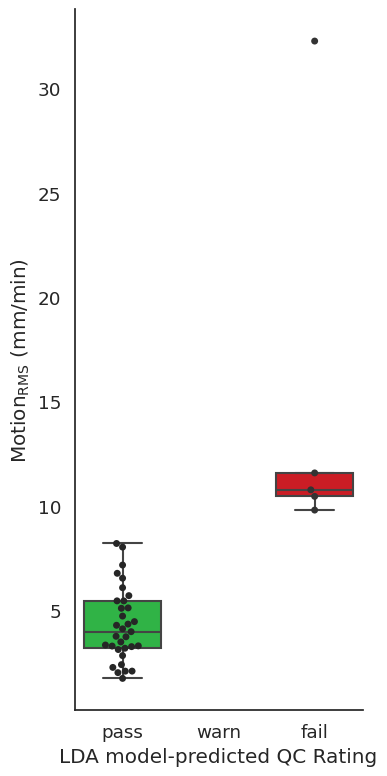

In [447]:
sns.set(style="white", font_scale=1.2)
plt.figure(figsize=(4,8))  
params = {'mathtext.default': 'regular' }  
plt.rcParams.update(params)
cmap = sns.color_palette('bright')
ax = sns.boxplot(x = 'model_predict_rating', y = 'mean_rms', palette = [ cmap[2], cmap[8], cmap[3] ], orient = 'v', data = struct_qa, order = ['pass', 'warn', 'fail'], showfliers=False)
ax = sns.swarmplot(x = 'model_predict_rating', y="mean_rms", data=struct_qa, hue = 'model_predict_rating', orient = 'v', color = '.2', order = ['pass', 'warn', 'fail'])


ax.get_legend().remove()

ax.set(xlabel='LDA model-predicted QC Rating', ylabel='$Motion_{RMS}\ (mm/min)$')
# ax.set_xticklabels(['Pass', 'Fail'])
sns.despine()
plt.tight_layout()
# plt.savefig('figs/manual_ratings_rms.png', dpi = 300)

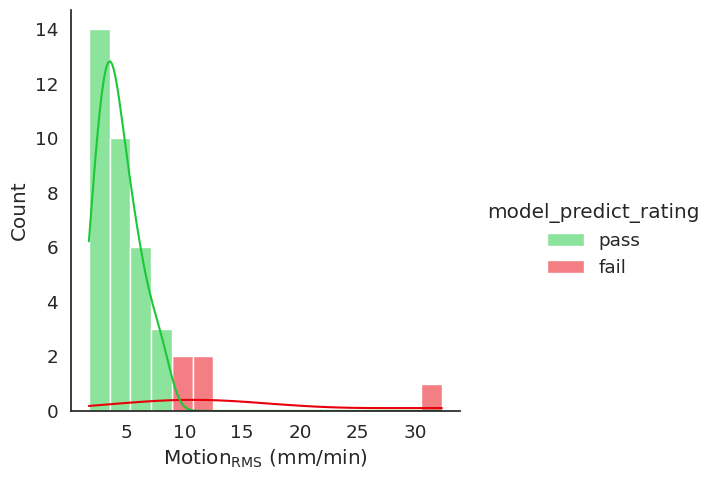

In [449]:
sns.set(style="white", font_scale=1.2)
ax = sns.displot(data=struct_qa, palette = [ cmap[2], cmap[3]], fill = True, x="mean_rms", hue="model_predict_rating", kde = True)

ax.set(xlabel='$Motion_{RMS}\ (mm/min)$')

# Image Quality | Euler

The Euler number is derived from the number of holes in the reconstructed cortical surface (Dale et al., 1999). Therefore, a lower Euler number indicates a higher image quality (fewer cortical holes), and visa versa. The Euler number has been reported to be a reliable measure of data quality, and it has been validated against other tools and with manual ratings (Rosen et al., 2018).  

In [28]:
import re

li = []

for i in sorted(glob.glob('/scratch/06028/tbweng/child-motion/fs_longitudinal/sub-mot???_run-0?/stats/aseg.stats')):
    sub = i.split('/')[6].split('_')[0].strip('sub-mot')
    ses = int(i.split('/')[6].split('_')[1].strip('run-0'))
    
    with open(i, 'r') as f:
        lines = f.readlines()
        for line in lines:
            if re.search(r'Total number of defect holes', line):
                euler = int(line.split(',')[3])
                break
                
    li.append([sub, ses, euler])
                             
euler_df = pd.DataFrame(li, columns = ['sub', 'ses', 'euler'])
euler_df = euler_df.merge(sub_coding, on = ['sub', 'ses'])
euler_df.head()

,sub,ses,euler,cond,dx
0,003,1,21,mold+,norm
1,003,2,58,mold-,norm
2,004,1,85,mold-,norm
3,004,2,82,mold+,norm
4,005,1,59,mold-,norm


In [33]:
%%R -i euler_df
library(likert) 
library(dplyr)
library(ggplot2)

euler_df %>%
    ggplot(aes(x=cond, y=euler)) + 
    geom_boxplot(aes(fill = cond), alpha = 0.8, size = .8, col = "black", outlier.shape = NA) +
    scale_fill_manual(values=c( '#333f48', '#BF5700')) +
    geom_line(aes(group = sub), size = 1, position = position_dodge(0.2)) + 
    geom_point(aes(fill=cond,group=sub, shape = dx), size = 3, position = position_dodge(0.2)) +
    ylab("Euler number") + theme(axis.title.x = element_blank()) + theme_classic(base_size=18) + guides(fill = FALSE) + theme(axis.title.x = element_blank())
    
ggsave('figs/euler.png', dpi = 300)

R[write to console]: Saving 6.67 x 6.67 in image



<img src="figs/euler.png" alt="euler" width="500"/>

In [137]:
euler_df.head()

,sub,ses,total_gm,cond,dx
0,003,1,719146.44,mold+,norm
1,003,2,724593.34,mold-,norm
2,004,1,707117.83,mold-,norm
3,004,2,710867.48,mold+,norm
4,005,1,893060.91,mold-,norm


In [14]:
%%R -i euler_df

library(ggplot2)
library(nlme)

m1 <- lme(euler ~ cond, random = ~1|sub, data=euler_df)
anova(m1)

            numDF denDF  F-value p-value
(Intercept)     1    18 39.14837  <.0001
cond            1    18  2.43903  0.1358


# Image Quality | CAT12

In [3]:
cat_df = pd.read_excel('CAT12/ChildMotion_data_tables_longi.xlsx', sheet_name=0 )

In [4]:
cat_df = cat_df.replace({"Group": {'stabilizer': "mold+", 'free': "mold-"}})

In [5]:
cat_df['sub'] = cat_df.Subject.str[-3:]
cat_df.head()

,SubNum,Subject,Run,Image Quality Rating (IQR),TIV,GM,WM,CSF,WM Hypo,Group,sub
0,sub-mot003_run-01,sub-mot003,1,85.91% (B),1348.17,728.53,471.00,148.28,0.36,mold+,003
1,sub-mot003_run-02,sub-mot003,2,85.66% (B),1373.52,743.83,478.08,151.23,0.38,mold-,003
2,sub-mot004_run-01,sub-mot004,1,84.54% (B),1277.53,711.26,421.94,143.34,0.99,mold-,004
3,sub-mot004_run-02,sub-mot004,2,85.42% (B),1262.54,714.88,408.79,138.38,0.50,mold+,004
4,sub-mot005_run-01,sub-mot005,1,85.80% (B),1653.33,914.22,593.57,145.06,0.48,mold-,005


In [6]:
cat_df = cat_df.merge(sub_coding, left_on = ['sub', 'Group'], right_on = ['sub', 'cond'] )
cat_df.head()

,SubNum,Subject,Run,Image Quality Rating (IQR),TIV,GM,WM,CSF,WM Hypo,Group,sub,ses,cond,dx
0,sub-mot003_run-01,sub-mot003,1,85.91% (B),1348.17,728.53,471.00,148.28,0.36,mold+,003,1,mold+,norm
1,sub-mot003_run-02,sub-mot003,2,85.66% (B),1373.52,743.83,478.08,151.23,0.38,mold-,003,2,mold-,norm
2,sub-mot004_run-01,sub-mot004,1,84.54% (B),1277.53,711.26,421.94,143.34,0.99,mold-,004,1,mold-,norm
3,sub-mot004_run-02,sub-mot004,2,85.42% (B),1262.54,714.88,408.79,138.38,0.50,mold+,004,2,mold+,norm
4,sub-mot005_run-01,sub-mot005,1,85.80% (B),1653.33,914.22,593.57,145.06,0.48,mold-,005,1,mold-,norm


In [7]:


cat_df[['IQR', 'grade']] = cat_df['Image Quality Rating (IQR)'].str.split('%', expand = True)

In [8]:
cat_df.IQR = cat_df.IQR.astype('float')

In [9]:
cat_df.head()

,SubNum,Subject,Run,Image Quality Rating (IQR),TIV,GM,WM,CSF,WM Hypo,Group,sub,ses,cond,dx,IQR,grade
0,sub-mot003_run-01,sub-mot003,1,85.91% (B),1348.17,728.53,471.00,148.28,0.36,mold+,003,1,mold+,norm,85.91,(B)
1,sub-mot003_run-02,sub-mot003,2,85.66% (B),1373.52,743.83,478.08,151.23,0.38,mold-,003,2,mold-,norm,85.66,(B)
2,sub-mot004_run-01,sub-mot004,1,84.54% (B),1277.53,711.26,421.94,143.34,0.99,mold-,004,1,mold-,norm,84.54,(B)
3,sub-mot004_run-02,sub-mot004,2,85.42% (B),1262.54,714.88,408.79,138.38,0.50,mold+,004,2,mold+,norm,85.42,(B)
4,sub-mot005_run-01,sub-mot005,1,85.80% (B),1653.33,914.22,593.57,145.06,0.48,mold-,005,1,mold-,norm,85.80,(B)


In [268]:
cat_df_long = pd.melt(cat_df, id_vars=['sub', 'ses', 'cond', 'dx'], value_vars=['TIV', 'GM', 'WM', 'CSF'])
cat_df_long = cat_df_long.merge(mean_rms[['sub', 'cond', 'mean_rms']], on = ['sub', 'cond'])


cat_df_long.head()


,sub,ses,cond,dx,variable,value,mean_rms
0,003,1,mold+,norm,TIV,1348.17,3.130087
1,003,1,mold+,norm,GM,728.53,3.130087
2,003,1,mold+,norm,WM,471.00,3.130087
3,003,1,mold+,norm,CSF,148.28,3.130087
4,003,2,mold-,norm,TIV,1373.52,3.493332


In [ ]:
%%R -i cat_df
library(likert) 
library(dplyr)
library(ggplot2)

p <- merge(cat_df, struct_qa_wide %>%
    ggplot(aes(x=cond, y=IQR)) + 
    geom_boxplot(aes(fill = cond), alpha = 0.8, size = .8, col = "black", outlier.shape = NA) +
    scale_fill_manual(values=c( '#333f48', '#BF5700')) +
    geom_line(aes(group = sub, col = rating ), size = 1, position = position_dodge(0.3)) + 
    geom_point(aes(fill=cond,group=sub, shape = dx), size = 4, alpha = .8, position = position_dodge(0.3)) +
    ylab("IQR") + theme(axis.title.x = element_blank()) + theme_classic(base_size=18) + guides(fill = FALSE) + theme(axis.title.x = element_blank())
    
ggsave('figs/iqr.png', plot = p, dpi = 300)
plot(p)

<img src="figs/iqr.png" alt="iqr" width="500"/>

In [30]:
cat_df.head()

,SubNum,Subject,Run,Image Quality Rating (IQR),TIV,GM,WM,CSF,WM Hypo,Group,sub,ses,cond,dx,IQR,grade
0,sub-mot003_run-01,sub-mot003,1,85.91% (B),1348.17,728.53,471.00,148.28,0.36,mold+,003,1,mold+,norm,85.91,(B)
1,sub-mot003_run-02,sub-mot003,2,85.66% (B),1373.52,743.83,478.08,151.23,0.38,mold-,003,2,mold-,norm,85.66,(B)
2,sub-mot004_run-01,sub-mot004,1,84.54% (B),1277.53,711.26,421.94,143.34,0.99,mold-,004,1,mold-,norm,84.54,(B)
3,sub-mot004_run-02,sub-mot004,2,85.42% (B),1262.54,714.88,408.79,138.38,0.50,mold+,004,2,mold+,norm,85.42,(B)
4,sub-mot005_run-01,sub-mot005,1,85.80% (B),1653.33,914.22,593.57,145.06,0.48,mold-,005,1,mold-,norm,85.80,(B)


In [210]:
%%R -i cat_df_long

m1 <- lme(volume ~ cond*rms, random = ~1|sub, data=cat_df_long %>% subset(variable == 'GM'))
anova(m1)

            numDF denDF     F-value    p-value
(Intercept)     1    18 2360.018305 0.00000000
cond            1    16    5.454945 0.03285895
rms             1    16   14.503762 0.00154517
cond:rms        1    16    4.778738 0.04402161


In [31]:
%%R -i cat_df

library(ggplot2)
library(nlme)

m1 <- lme(IQR ~ cond, random = ~1|Subject, data=cat_df)
anova(m1)

            numDF denDF  F-value p-value
(Intercept)     1    18 68466.55  <.0001
cond            1    18     2.84  0.1093


In [101]:
%%R

m1 <- lme(GM ~ cond, random = ~1|Subject, data=cat_df)
anova(m1)

            numDF denDF     F-value  p-value
(Intercept)     1    18 2429.153659 0.000000
cond            1    18    2.743107 0.115003


In [229]:
from scipy import stats
stats.ttest_rel(cat_df[cat_df['cond'] == 'mold+'].IQR.values,cat_df[cat_df['cond'] == 'mold-'].IQR.values)

Ttest_relResult(statistic=1.684619489720051, pvalue=0.10932162945265197)

# Impact on brain volume estimates (CAT12, FreeSurfer, & SIENA)


In [102]:
cat_df_long.head()

,sub,ses,cond,dx,variable,value
0,003,1,mold+,norm,TIV,1348.17
1,003,2,mold-,norm,TIV,1373.52
2,004,1,mold-,norm,TIV,1277.53
3,004,2,mold+,norm,TIV,1262.54
4,005,1,mold-,norm,TIV,1653.33


<function matplotlib.pyplot.show(*args, **kw)>

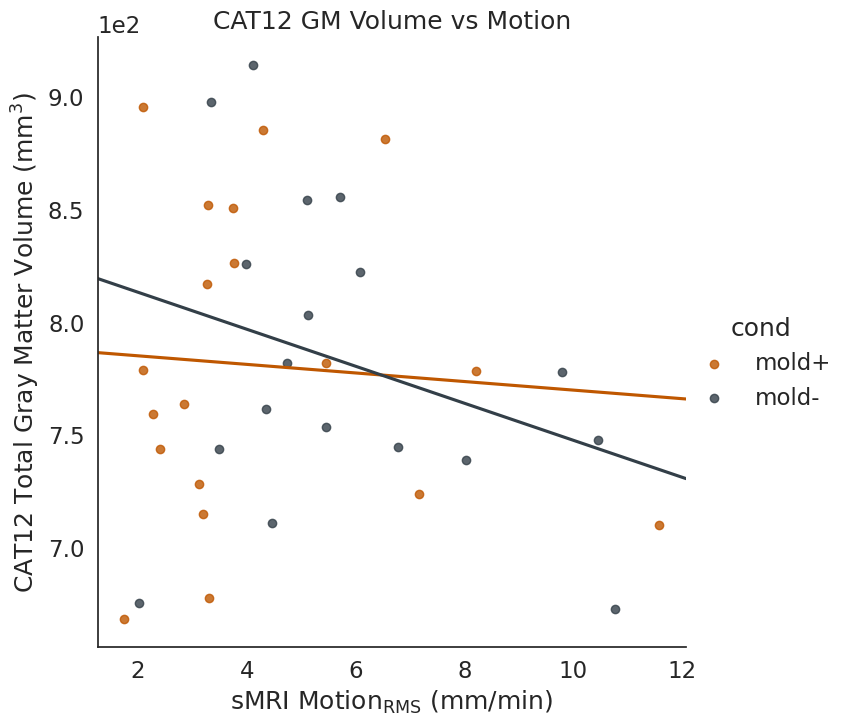

In [310]:
params = {'mathtext.default': 'regular' }          
plt.rcParams.update(params)

sdf = cat_df_long[cat_df_long['variable'] == 'GM']

import matplotlib.ticker as mtick


sdf = sdf[sdf['mean_rms'] < 20] # remove outlier
sns.set(font_scale=1.5)
sns.set_style("white")
g = sns.lmplot(x = 'mean_rms', y = 'value', hue='cond', height = 7, aspect = 1,
               ci = None, truncate = False, line_kws={'label':"Reduced major axis"}, 
               palette = ['#BF5700', '#333f48'], data =  sdf)
g.set(xlabel='sMRI Motion$_{RMS}$ (mm/min)', ylabel='CAT12 Total Gray Matter Volume ($mm^3$)', title='CAT12 GM Volume vs Motion')
for ax in g.axes.flatten():
    ax.ticklabel_format(style='sci', scilimits=(0,0), axis='y')

plt.show

# FreeSurfer 


In [71]:
li = []

for i in sorted(glob.glob('/scratch/06028/tbweng/child-motion/fs_longitudinal/*.long*')):
    fsid = i.split('/')[6].split('.')[0]
    base = i.split('/')[6].split('_')[0]
    sub = i[-3:]
    run = int(i.split('/')[6].split('_')[1].split('.')[0][-1])
    li.append([fsid, base, sub, run])
    
df = pd.DataFrame(li, columns = ['fsid', 'fsid-base', 'sub', 'ses'])
df.head()

,fsid,fsid-base,sub,ses
0,sub-mot003_run-01,sub-mot003,003,1
1,sub-mot003_run-02,sub-mot003,003,2
2,sub-mot004_run-01,sub-mot004,004,1
3,sub-mot004_run-02,sub-mot004,004,2
4,sub-mot005_run-01,sub-mot005,005,1


In [69]:
df = df.merge(sub_coding, on = ['sub', 'ses'])
df.head()

,fsid,fsid-base,sub,ses,cond,dx
0,sub-mot003_run-01,sub-mot003,003,1,mold+,norm
1,sub-mot003_run-02,sub-mot003,003,2,mold-,norm
2,sub-mot004_run-01,sub-mot004,004,1,mold-,norm
3,sub-mot004_run-02,sub-mot004,004,2,mold+,norm
4,sub-mot005_run-01,sub-mot005,005,1,mold-,norm


In [22]:
!ls /scratch/06028/tbweng/child-motion/HDBET_brains-SIENA/sub-mot003_run-01.long.sub-mot003/label

In [233]:
import re

li = []

for i in sorted(glob.glob('/scratch/06028/tbweng/child-motion/fs_longitudinal/sub-mot???_run-0?.long.sub-mot0??/stats/aseg.stats')):
    sub = i.split('/')[6].split('_')[0].strip('sub-mot')
    ses = int(i.split('/')[6].split('_')[1].split('.')[0].strip('run-0'))
    
    with open(i, 'r') as f:
        lines = f.readlines()
        for line in lines:
            if re.search(r'Measure TotalGray', line):
                total_gm = float(line.split(',')[3])
                break
                
    li.append([sub, ses, total_gm])
                             
tgm_df = pd.DataFrame(li, columns = ['sub', 'ses', 'total_gm'])
tgm_df.head()


,sub,ses,total_gm
0,003,1,719146.436422
1,003,2,724593.336240
2,004,1,707117.828465
3,004,2,710867.476577
4,005,1,893060.905486


In [234]:
tgm_df = tgm_df.merge(sub_coding, on = ['sub', 'ses'])


In [237]:
tgm_df.head()

,sub,ses,total_gm,cond,dx
0,003,1,719146.436422,mold+,norm
1,003,2,724593.336240,mold-,norm
2,004,1,707117.828465,mold-,norm
3,004,2,710867.476577,mold+,norm
4,005,1,893060.905486,mold-,norm


In [244]:
tgm_df = tgm_df.merge(mean_rms[['sub', 'cond','value']], on = ['sub', 'cond'])
tgm_df.head()

,sub,ses,total_gm,cond,dx,value
0,003,1,719146.436422,mold+,norm,3.130087
1,003,2,724593.336240,mold-,norm,3.493332
2,004,1,707117.828465,mold-,norm,4.466768
3,004,2,710867.476577,mold+,norm,3.191968
4,005,1,893060.905486,mold-,norm,4.120252


<function matplotlib.pyplot.show(*args, **kw)>

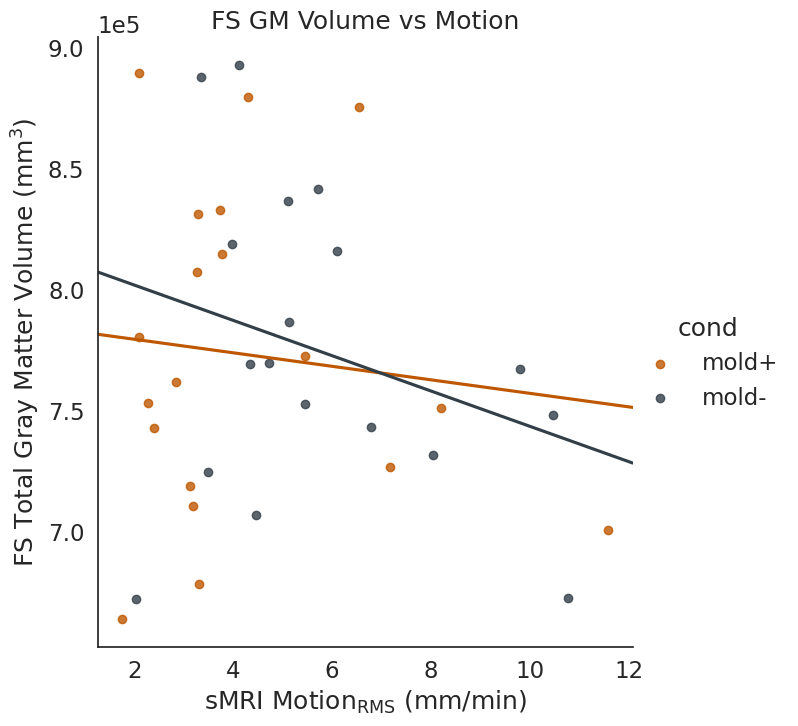

In [309]:
import matplotlib.ticker as mtick
params = {'mathtext.default': 'regular' }          
plt.rcParams.update(params)

sdf = mean_rms.merge(tgm_df[['sub','cond','total_gm']], on = ['sub', 'cond'])
sdf = sdf[sdf['mean_rms'] < 20] # remove outlier
sns.set(font_scale=1.5)
sns.set_style("white")

g = sns.lmplot(x = 'mean_rms', y = 'total_gm', hue='cond', height = 7, aspect = 1,
               ci = None, truncate = False, line_kws={'label':"Reduced major axis"}, 
               palette = ['#BF5700', '#333f48'], data =  sdf)
g.set(xlabel='sMRI Motion$_{RMS}$ (mm/min)', ylabel='FS Total Gray Matter Volume ($mm^3$)', title='FS GM Volume vs Motion')
for ax in g.axes.flatten():
    ax.ticklabel_format(style='sci', scilimits=(0,0), axis='y')

plt.show

# SIENA

FSL's tool for estimating brain volume change

In [50]:
li = []
for f in glob.glob('/scratch/06028/tbweng/child-motion/HDBET_brains-SIENA/sub-mot*_siena/report.siena'):
    with open(f, "r") as f1:
        pbvc = f1.readlines()[-1].split(' ')[1]
        sub = f.split('/')[6].split('_')[0].split('mot')[1]
        li.append([sub, pbvc])
                             
pbvc = pd.DataFrame(li, columns = ['sub', 'pbvc'])
pbvc.head()

,sub,pbvc
0,010,1.6758050000
1,022,-.3442140000
2,005,-1.5108550000
3,017,-.2467861500
4,021,.4330560000


In [51]:
pbvc = pbvc.merge(sub_coding.drop_duplicates(subset=['sub']), how = 'left', on = 'sub')
pbvc.head()

,sub,pbvc,ses,cond,dx
0,010,1.6758050000,1,mold+,norm
1,022,-.3442140000,1,mold-,adhd
2,005,-1.5108550000,1,mold-,norm
3,017,-.2467861500,1,mold-,adhd
4,021,.4330560000,1,mold+,adhd


In [52]:
# add mult factor based on mold order
# SIENA pbvc is change from run1 to run2, mult factor=-1 if first scan was mold+
pbvc['mul'] = np.where(pbvc['cond']=='mold+', -1, 1)

In [53]:
pbvc['pbvc'] = pd.to_numeric(pbvc['pbvc'])

In [54]:
pbvc['pbvc_adj'] = pbvc['pbvc'] * pbvc['mul']

In [179]:
pbvc = pbvc.merge(mean_rms[['sub', 'cond', 'value']], on = ['sub', 'cond'])
pbvc = pbvc.rename({'value': 'rms', 'variable': 'cond'}, axis=1) 
pbvc.head()

,sub,pbvc,ses,cond,dx,mul,pbvc_adj,rms
0,010,1.675805,1,mold+,norm,-1,-1.675805,2.273230
1,022,-0.344214,1,mold-,adhd,1,-0.344214,32.263024
2,005,-1.510855,1,mold-,norm,1,-1.510855,4.120252
3,017,-0.246786,1,mold-,adhd,1,-0.246786,5.104493
4,021,0.433056,1,mold+,adhd,-1,-0.433056,3.305602


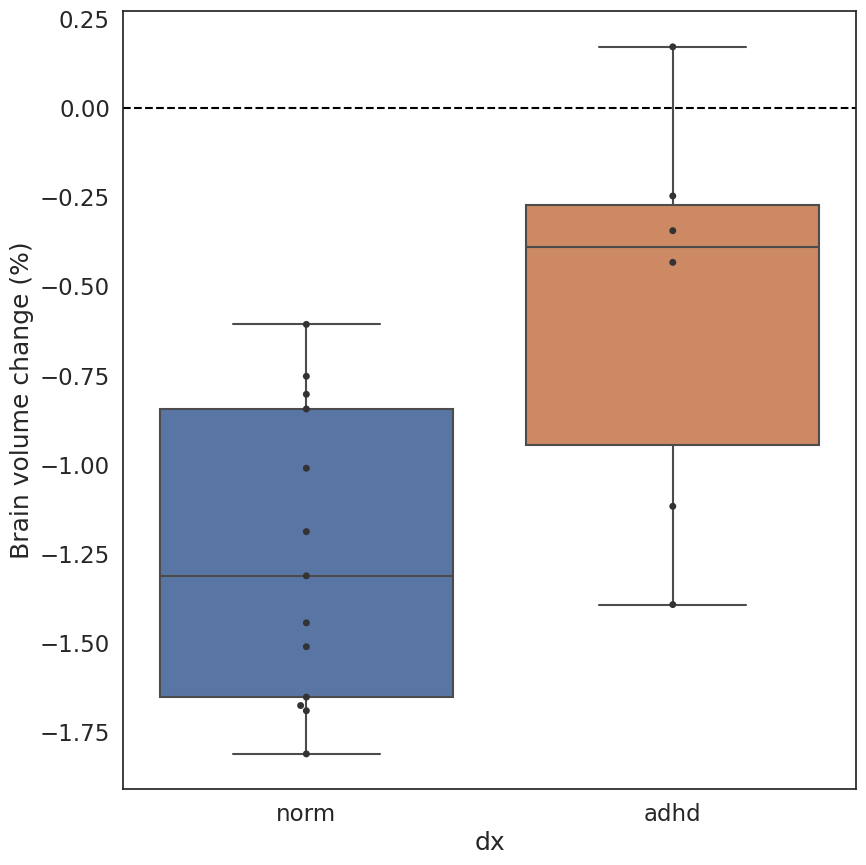

In [57]:
params = {'mathtext.default': 'regular' }          
plt.rcParams.update(params)

sns.set(font_scale=1.5)
sns.set_style("white")

plt.figure(figsize=(9,9))
ax = sns.boxplot(x="dx", y="pbvc_adj", data=pbvc)
ax = sns.swarmplot(x="dx", y="pbvc_adj", data=pbvc, color=".2")
ax.set(ylabel='Brain volume change (%)')
plt.axhline(y=0, color='black', linestyle='--')
plt.tight_layout()
plt.savefig('figs/siena_pbvc.png',dpi=300)
plt.show()